# OULAD : Règles d'Association pour Découvrir les Schémas d'Abandon

Ce notebook utilise l'algorithme Apriori pour découvrir des schémas de comportements menant à l'abandon scolaire (étudiants ayant abandonné ou échoué) dans le jeu de données Open University Learning Analytics Dataset (OULAD). Les règles d'association identifient des relations fréquentes entre les caractéristiques démographiques, académiques et d'engagement, et le risque d'abandon (`at_risk = 1`).

In [4]:
# Importer les bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

# Configurer le style des graphiques
plt.style.use('seaborn-v0_8') 
sns.set_palette('viridis')
%matplotlib inline

## Chargement des Données

Charger le jeu de données prétraité (`oulad_preprocessed.csv`) ou recréer à partir des fichiers CSV OULAD si nécessaire.

In [5]:
def charger_donnees_oulad():

    # Essayer de charger le fichier prétraité
    df = pd.read_csv('../data/oulad_preprocessed.csv')
    print('Jeu de données prétraité chargé depuis oulad_preprocessed.csv')

    return df

df = charger_donnees_oulad()
df.head()

Jeu de données prétraité chargé depuis oulad_preprocessed.csv


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,total_clicks,at_risk
0,AAA,2013J,11391,0,East Anglian Region,3,90.0,55<=,0,240,0,Pass,82.000000,934.0,0
1,AAA,2013J,28400,1,Scotland,3,20.0,35-55,0,60,0,Pass,66.400000,1435.0,0
2,AAA,2013J,30268,1,North Western Region,2,30.0,35-55,0,60,1,Withdrawn,72.768254,281.0,1
3,AAA,2013J,31604,1,South East Region,2,50.0,35-55,0,60,0,Pass,76.000000,2158.0,0
4,AAA,2013J,32885,1,West Midlands Region,1,50.0,0-35,0,60,0,Pass,54.400000,1034.0,0


## Prétraitement pour les Règles d'Association

Discretiser les variables continues et convertir les données en format binaire pour l'algorithme Apriori.

In [6]:
def discretiser_donnees(df):
    # Discretiser les variables continues
    df['score_cat'] = pd.qcut(df['score'], q=3, labels=['Score_Faible', 'Score_Moyen', 'Score_Élevé'])
    df['clicks_cat'] = pd.qcut(df['total_clicks'], q=3, labels=['Clicks_Faible', 'Clicks_Moyen', 'Clicks_Élevé'])
    df['imd_band_cat'] = pd.qcut(df['imd_band'], q=3, labels=['IMD_Faible', 'IMD_Moyen', 'IMD_Élevé'])
    
    # Convertir les variables catégoriques en chaînes
    df['gender'] = df['gender'].map({0: 'Masculin', 1: 'Féminin'})
    education_mapping = {
        0: 'Aucune_Qualification',
        1: 'Inférieur_A_Level',
        2: 'A_Level',
        3: 'HE_Qualification',
        4: 'Post_Graduate'
    }
    df['highest_education'] = df['highest_education'].map(education_mapping)
    age_mapping = {0: 'Âge_0-35', 1: 'Âge_35-55', 2: 'Âge_55+'}
    df['age_band'] = df['age_band'].map(age_mapping)
    df['disability'] = df['disability'].map({0: 'Non_Handicapé', 1: 'Handicapé'})
    df['at_risk'] = df['at_risk'].map({0: 'Non_À_Risque', 1: 'À_Risque'})
    
    # Sélectionner les colonnes pour les règles d'association
    columns = ['gender', 'highest_education', 'imd_band_cat', 'age_band', 'score_cat', 'clicks_cat', 'disability', 'at_risk']
    
    # Créer un DataFrame binaire (one-hot encoding)
    df_binary = pd.get_dummies(df[columns])
    
    return df_binary

df_binary = discretiser_donnees(df)
df_binary.head()

,gender_Féminin,gender_Masculin,highest_education_A_Level,highest_education_Aucune_Qualification,highest_education_HE_Qualification,highest_education_Inférieur_A_Level,highest_education_Post_Graduate,imd_band_cat_IMD_Faible,imd_band_cat_IMD_Moyen,imd_band_cat_IMD_Élevé,score_cat_Score_Faible,score_cat_Score_Moyen,score_cat_Score_Élevé,clicks_cat_Clicks_Faible,clicks_cat_Clicks_Moyen,clicks_cat_Clicks_Élevé,disability_Handicapé,disability_Non_Handicapé,at_risk_Non_À_Risque,at_risk_À_Risque
0,False,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,True,True,False
1,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,True,False
2,True,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True
3,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,True,False
4,True,False,False,False,False,True,False,False,True,False,True,False,False,False,True,False,False,True,True,False


## Génération des Règles d'Association

Appliquer l'algorithme Apriori pour trouver des itemsets fréquents et générer des règles d'association.

In [7]:
# Générer les itemsets fréquents avec Apriori
frequent_itemsets = apriori(df_binary, min_support=0.1, use_colnames=True)

# Générer les règles d'association
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# Filtrer les règles avec 'À_Risque' dans le conséquent
rules_at_risk = rules[rules['consequents'].apply(lambda x: 'at_risk_À_Risque' in x)]

# Trier par lift
rules_at_risk = rules_at_risk.sort_values(by='lift', ascending=False)

# Afficher les règles
print('Règles d\'association menant à l\'abandon :')
rules_at_risk[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

Règles d'association menant à l'abandon :


,antecedents,consequents,support,confidence,lift
517,"(gender_Masculin, clicks_cat_Clicks_Faible)","(at_risk_À_Risque, disability_Non_Handicapé, s...",0.129138,0.788350,2.157586
512,"(disability_Non_Handicapé, gender_Masculin, cl...","(at_risk_À_Risque, score_cat_Score_Faible)",0.129138,0.882205,2.136551
350,"(gender_Masculin, clicks_cat_Clicks_Faible)","(at_risk_À_Risque, score_cat_Score_Faible)",0.144295,0.880877,2.133334
538,"(disability_Non_Handicapé, highest_education_I...","(at_risk_À_Risque, score_cat_Score_Faible)",0.116958,0.846923,2.051104
438,"(highest_education_Inférieur_A_Level, clicks_c...","(at_risk_À_Risque, score_cat_Score_Faible)",0.133710,0.845393,2.047398
460,"(imd_band_cat_IMD_Faible, clicks_cat_Clicks_Fa...","(at_risk_À_Risque, score_cat_Score_Faible)",0.140797,0.842637,2.040724
549,"(disability_Non_Handicapé, imd_band_cat_IMD_Fa...","(at_risk_À_Risque, score_cat_Score_Faible)",0.122204,0.842428,2.040218
542,"(highest_education_Inférieur_A_Level, clicks_c...","(at_risk_À_Risque, disability_Non_Handicapé, s...",0.116958,0.739476,2.023826
486,(clicks_cat_Clicks_Faible),"(at_risk_À_Risque, score_cat_Score_Faible, dis...",0.244715,0.732954,2.005975
553,"(imd_band_cat_IMD_Faible, clicks_cat_Clicks_Fa...","(at_risk_À_Risque, disability_Non_Handicapé, s...",0.122204,0.731362,2.001620


## Visualisation des Règles

Visualiser les règles sous forme de tableau et une heatmap des co-occurrences.

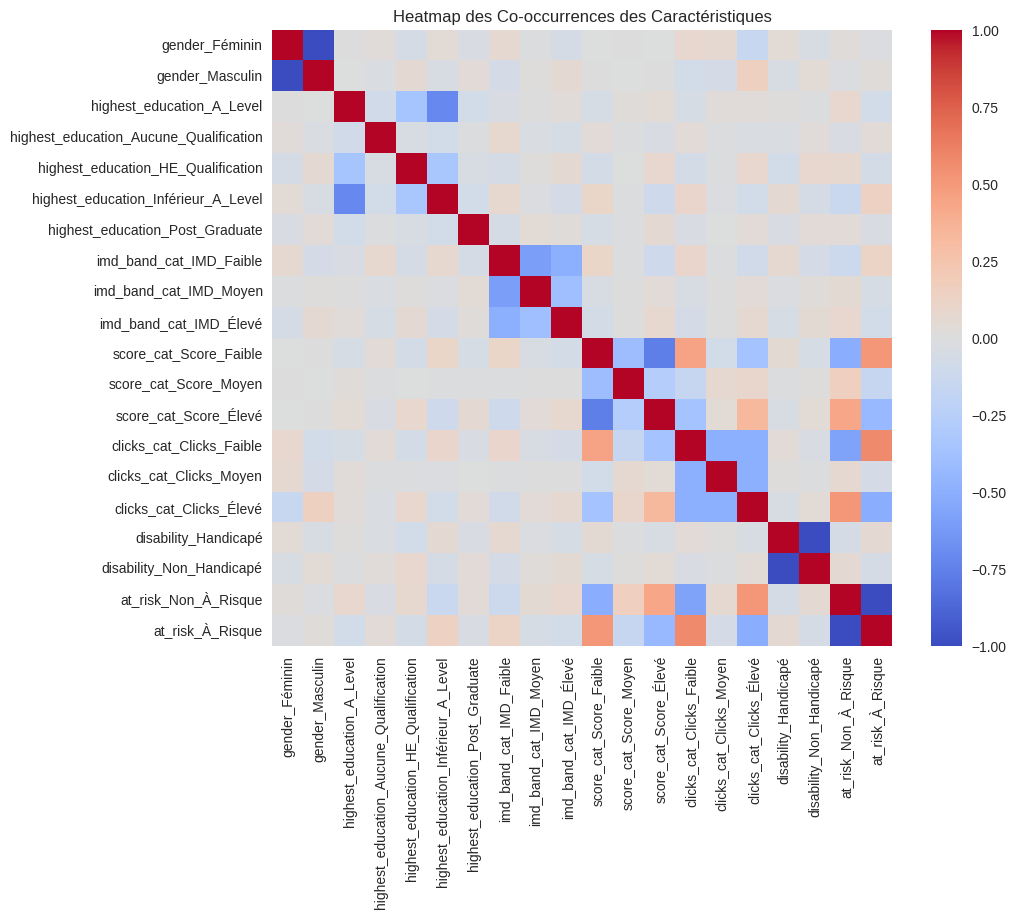

In [8]:
# Afficher un tableau stylisé
st_rules = rules_at_risk[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)
st_rules['antecedents'] = st_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
st_rules['consequents'] = st_rules['consequents'].apply(lambda x: ', '.join(list(x)))
st_rules.style.set_caption('Top 10 Règles d\'Association menant à l\'Abandon')

# Heatmap des co-occurrences
plt.figure(figsize=(10, 8))
corr = df_binary.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Heatmap des Co-occurrences des Caractéristiques')
plt.show()

## Sauvegarde des Règles

Sauvegarder les règles d'association dans un fichier CSV pour une utilisation future.

In [9]:
# Sauvegarder les règles
rules_at_risk.to_csv('association_rules_at_risk.csv', index=False)
print('Règles d\'association sauvegardées sous association_rules_at_risk.csv')

Règles d'association sauvegardées sous association_rules_at_risk.csv
